##### setting

get_lat_lon(df,from_stop,to_stop)


get_distric(data,lng_start="lng_start",lat_start="lat_start",districts = districts)

In [1]:
from folium.plugins import HeatMap
from folium.plugins import BeautifyIcon
from branca.colormap import linear
from branca.element import Template, MacroElement
from selenium import webdriver
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
import pandas as pd
import duckdb
import folium
import os
import random
import geopandas as gpd
import requests
import json
import dask

from matplotlib import font_manager

# 設置支持中文的字體，這裡以 "SimHei" 為例，你也可以選擇其他支持中文的字體
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 正常顯示負號

pd.set_option('display.max_columns', None)

conn = duckdb.connect(database='warehouse\data_sandbox.duckdb')
sna_loc = conn.execute("SELECT distinct sna, latitude as lat,longitude as lng FROM youbike").fetch_df()
conn.close()

gdf = gpd.read_file('project\map_application\static\data\週末起訖站點統計_202307.geojson')

def get_lat_lon(df,from_stop,to_stop):
    return df.merge(sna_loc, left_on=f"{from_stop}", right_on="sna")\
    .rename(columns={"lat":"lat_start","lng":"lng_start"})\
    .drop(columns="sna")\
    .merge(sna_loc, left_on=f"{to_stop}", right_on="sna")\
    .rename(columns={"lat":"lat_end","lng":"lng_end"})\
    .drop(columns="sna")

In [2]:
from shapely.geometry import Point

districts = gpd.read_file(r'D:\sandbox_git\project\map_application\static\geojson\OSM_DATA.geojson')

def get_distric(data,lng_start="lng_start",lat_start="lat_start",districts = districts):
    # 將經緯度轉換為 Point 物件，並放入 GeoDataFrame 中
    geometry = [Point(xy) for xy in zip(data[f'{lng_start}'], data[f'{lat_start}'])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry)

    # 設定 CRS (坐標參考系統)，這裡假設是 WGS84 (EPSG:4326)
    geo_data.set_crs(epsg=4326, inplace=True)
    districts.set_crs(epsg=4326, inplace=True)

    joined_data = gpd.sjoin(geo_data, districts, how='left', op='within')

    geo_data['district_name'] = joined_data['name']

    return geo_data

##### 變化率GIF圖

In [ ]:
conn = duckdb.connect(database='warehouse\data_sandbox.duckdb')
df = conn.execute("SELECT * FROM youbike").fetch_df()
conn.close()

df = df[['sno', 'sna', 'sarea','fetch_time','latitude', 'longitude','available_rent_bikes','total','temperature','description']].sort_values(['sno','fetch_time'], ascending=True)
df["fetch_time"] = pd.to_datetime(df["fetch_time"])

# 定義計算變化率的函數
def calculate_change_rate(group):
    # 計算 available_rent_bikes 的變化率
    group['change_rate'] = group['available_rent_bikes'].pct_change().fillna(0)
    
    # 計算 fetch_time 的時間差（以分鐘計算）
    group['time_diff'] = group['fetch_time'].diff().dt.total_seconds() / 60
    
    # 如果時間差超過 20 分鐘，變化率設為 0
    group.loc[group['time_diff'] > 12, 'change_rate'] = 0
    
    return group

df_pct = df.groupby('sno',as_index=False).apply(calculate_change_rate)
df_available = df_pct.query("~time_diff.isna()").query("time_diff <12").query("change_rate != inf")

def generate_html(df, threshold=0.1):
    if os.path.exists(rf"D:\\sandbox_git\\warehouse\\bike_html\\bike_change_rate_map_{df.fetch_time.unique()[0].strftime('%Y%m%d%H%M')}.html"):
        print("exists")
        pass
    else:
        # Create a base map
        m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=13, tiles='CartoDB positron')

        # Normalize change_rate to a range between 0 and 1 for color mapping
        min_change_rate = df['change_rate'].min()
        max_change_rate = df['change_rate'].max()
        df['norm_change_rate'] = (df['change_rate'] - min_change_rate) / (max_change_rate - min_change_rate)
        df['norm_change_rate'] = df['norm_change_rate'].fillna(0)
        
        # Create a custom colormap
        colormap = linear.RdYlBu_11.scale(min_change_rate, max_change_rate)  # Red for high, blue for low
        colormap = colormap.to_step(n=10)  # Discretize the color map into 10 steps
        
        # Add points to the map
        for i, row in df.iterrows():
            # 如果 change_rate 絕對值小於 threshold，顯示為灰色
            if abs(row['change_rate']) < threshold:
                color = 'grey'
                fill_opacity = 0.01
                radius=1
            else:
                color = colormap(row['change_rate'])
                fill_opacity = 0.4
                radius=6
            
            folium.CircleMarker(
                location=(row['latitude'], row['longitude']),
                radius=radius, 
                color=color,  
                fill=True,
                fill_opacity=fill_opacity,
                popup=f"Change Rate: {row['change_rate']}"
            ).add_to(m)

        # Add the colormap legend
        colormap.add_to(m)

        # 添加顯示 fetch_time 的文字
        timestamp = df.fetch_time.unique()[0].strftime('%Y-%m-%d %H:%M:%S')
        print(timestamp)
        
        # # 自定義的 HTML 模板，將時間顯示在右下角
        # template = """
        # {% macro html(this, kwargs) %}
        # <div style="position: fixed;
        #             bottom: 750px; right: 50px; z-index: 9999;
        #             background-color: black; padding: 5px;
        #             font-size: 24px; color: white">
        # Fetched at: """ + timestamp + """
        # </div>
        # {% endmacro %}
        # """
        
        # # 添加模板到地圖
        # macro = MacroElement()
        # macro._template = Template(template)
        # m.get_root().add_child(macro)

        # Save the map
        m.save(f"D:\\sandbox_git\\warehouse\\bike_html\\bike_change_rate_map_{df.fetch_time.unique()[0].strftime('%Y%m%d%H%M')}.html")

for time in df_available.fetch_time.unique():
    df = df_available.query("fetch_time == @time")
    generate_html(df)

# Set up the Selenium driver (ensure you have the correct driver installed)
options = webdriver.ChromeOptions()
options.add_argument('headless')
driver = webdriver.Chrome(options=options)

# Folder paths
html_folder = 'D:/sandbox_git/warehouse/bike_html'
output_folder = 'D:/sandbox_git/warehouse/bike_images'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Convert each HTML file to an image
for file_name in os.listdir(html_folder):
    if file_name.endswith('.html'):
        file_path = os.path.join(html_folder, file_name)
        output_image_path = os.path.join(output_folder, file_name.replace('.html', '.png'))

        driver.get(f'file:///{file_path}')
        driver.set_window_size(1920, 1080)  # Adjust the window size as needed
        driver.save_screenshot(output_image_path)

driver.quit()

# Folder where images are saved
image_folder = 'D:/sandbox_git/warehouse/bike_images'
output_gif = 'D:/sandbox_git/warehouse/bike_change_rate_map.gif'

# Get all the images
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()  # Ensure correct order

# Open images and create a GIF
images = [Image.open(img_file) for img_file in image_files]
images[0].save(output_gif, save_all=True, append_images=images[1:], duration=90, loop=0)

##### 週末起訖站點

In [3]:
# 讀取 GeoJSON 檔案
gdf = gpd.read_file('warehouse\週末起訖站點統計_202307.geojson')\
        .sort_values(by=["on_stop_id","off_stop_id"])\
            .reset_index()\
                .drop(columns="index")

gdf['route'] = gdf.apply(lambda row: tuple(sorted([row['on_stop_id'], row['off_stop_id']])), axis=1)

In [4]:
gpd.GeoDataFrame(gdf[["sum_of_txn_times","width","geometry"]], geometry='geometry')\
    .to_file(r"D:\sandbox_git\project\map_application\static\geojson\weekend_route.geojson", driver="GeoJSON")

In [ ]:
gdf.sort_values("sum_of_txn_times",ascending=False).head(100)

In [4]:
results = gdf.sort_values(by=["on_stop_id","off_stop_id"])\
    .groupby("route",as_index=False)\
    .agg(mean_of_txn_times_byRoutes=("sum_of_txn_times","mean"))\
    .merge(gdf[["on_stop_id","off_stop_id","on_stop","off_stop","route","geometry"]].drop_duplicates(subset="route"), on="route",validate="1:1")

results["route_pct"] = (results["mean_of_txn_times_byRoutes"] / results["mean_of_txn_times_byRoutes"].sum()) *100

In [ ]:
results.sort_values("mean_of_txn_times_byRoutes",ascending=False)

In [ ]:
get_lat_lon(results,"on_stop","off_stop")

##### 資料分入行政區

In [ ]:
from shapely.geometry import Point

districts = gpd.read_file(r'D:\sandbox_git\project\map_application\static\geojson\OSM_DATA.geojson')

# 假設你有座標點資料 (DataFrame)，包含經緯度
data = get_lat_lon(results,"on_stop","off_stop")

def get_distric(data,lng_start="lng_start",lat_start="lat_start"):
    # 將經緯度轉換為 Point 物件，並放入 GeoDataFrame 中
    geometry = [Point(xy) for xy in zip(data[f'{lng_start}'], data[f'{lat_start}'])]
    geo_data = gpd.GeoDataFrame(data, geometry=geometry)

    # 設定 CRS (坐標參考系統)，這裡假設是 WGS84 (EPSG:4326)
    geo_data.set_crs(epsg=4326, inplace=True)
    districts.set_crs(epsg=4326, inplace=True)

    # 使用 sjoin 進行空間聯接，將每個點對應到行政區
    # 'within' 表示點位於 Polygon 內
    joined_data = gpd.sjoin(geo_data, districts, how='left', op='within')

    # 假設 districts DataFrame 中有一個欄位是 'district_name'，表示行政區名稱
    # 我們會將該欄位加入到點資料中
    geo_data['district_name'] = joined_data['name']

    return geo_data

get_distric(data,"lng_start","lat_start")
# 查看結果，原始的點資料加上對應的行政區名稱
# geo_data.to_csv(r"D:\sandbox_git\warehouse\insight\週末起訖站點統計_cleaned.csv",index=False)

In [ ]:
import folium

# 創建地圖對象，設置中心點及縮放級別
m = folium.Map(location=[25.03, 121.5], zoom_start=14)

# 使用 style_function 設定每條線的樣式，包括 width
def style_function(feature):
    return {
        'color': 'blue',          # 線條顏色
        'weight': feature['properties']['width'],  # 設定寬度
        'opacity': 0.8            # 透明度
    }

# 將 GeoJSON 數據加入到地圖上，並應用 style_function
folium.GeoJson(gdf.iloc[:900], style_function=style_function).add_to(m)

# 顯示地圖
m

In [ ]:
gdf[["on_stop_id","on_stop"]].drop_duplicates(subset=["on_stop_id"])

In [ ]:
# 創建一個字典來存放每個 on_stop_id 的顏色
on_stop_colors = {}
unique_on_stops = gdf['on_stop_id'].unique()

# 生成隨機顏色對應於每個 on_stop_id
colors = list(mcolors.CSS4_COLORS.values())  # 使用 CSS4 定義的顏色
random.shuffle(colors)  # 隨機打亂顏色列表

for i, on_stop_id in enumerate(unique_on_stops):
    on_stop_colors[on_stop_id] = colors[i % len(colors)]  # 確保顏色不會超出列表範圍

# 設定地圖的初始中心點與縮放級別
center_lat = gdf['geometry'].centroid.y.mean()
center_lon = gdf['geometry'].centroid.x.mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='cartodb positron')

# 遍歷資料並繪製對應的 LINESTRING
for _, row in gdf.iterrows():
    if row['geometry'].geom_type == 'LineString':
        coords = list(row['geometry'].coords)  # 取得 LINESTRING 的經緯度
        locations = [(lat, lon) for lon, lat in coords]  # folium 需要 (緯度, 經度) 的順序
        
        # 根據 on_stop_id 選擇顏色
        line_color = on_stop_colors[row['on_stop_id']]
        
        # 使用 folium 繪製線段，並根據 'width' 設置線條的寬度
        folium.PolyLine(
            locations=locations,
            color=line_color,
            weight=row['width'],  # 使用對應的線寬
            opacity=0.8
        ).add_to(m)

# 保存或顯示地圖
m.save("transit_line_map.html")  # 保存為 HTML 文件
m  # 若在 Jupyter Notebook 或 IPython 中執行，這樣可以直接顯示地圖

##### 需求預測視覺化

In [ ]:
# 假設你的資料存放在 df 中
df = gpd.read_file('D:\sandbox_git\warehouse\未設站區域需求預測_202303.geojson')   

# 建立一個類別對應顏色的字典
category_color_map = {
    '低': 'blue',
    '極低': 'purple',
    '中低': 'green',
    '中': 'orange',
    '高': 'red'
}

# 初始化地圖
fig = go.Figure()

# 遍歷每個類別並繪製對應的 POLYGON
for category, color in category_color_map.items():
    # 過濾資料集只保留該類別的資料
    filtered_df = df[df['category'] == category]
    
    # 繪製每一個 POLYGON
    for _, row in filtered_df.iterrows():
        # 獲取 POLYGON 的邊界座標
        if row['geometry'].geom_type == 'Polygon':
            x, y = row['geometry'].exterior.xy
            # 將 array.array 轉換為 list
            lon = list(x)
            lat = list(y)
            fig.add_trace(go.Scattermapbox(
                fill="toself",
                lon=lon,
                lat=lat,
                mode='lines',
                line=dict(width=2, color=color),
                fillcolor=color,
                name=category
            ))
            
# 設定 Mapbox 底圖樣式和中心位置
fig.update_layout(
    mapbox_style="dark",  # 使用 Mapbox 的 dark-v11 底圖
    mapbox_accesstoken="pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ",  # 替換成你的 Mapbox access token
    mapbox_zoom=10,  # 設定縮放比例
    mapbox_center={"lat": 25.0330, "lon": 121.5654},  # 根據你的資料調整中心位置
    title="Polygon Map with Category Colors"
)

# 顯示地圖
fig.show()


##### 站點分群結果

從互補站點擷取前 500 互補人數排名的站點，
平均站點為 25個，定義平日20天至少全部被騎走為高流量。因此找出 一個月中互補人數高達 500人的為高通勤
接著搜尋各站點 1 km 以內的 POI 前五名，
以 2 KM 為 分組距離在地圖上繪製多邊形

In [6]:
# 讀取 CSV 檔案
df = pd.read_csv("D:\sandbox_git\warehouse\互補站點1.csv")\
    .rename(columns={'longitude1（經度）':'longitude1', 'latitude1（緯度）':'latitude1'})\
    .merge(gdf[["on_stop_id","on_stop"]].drop_duplicates(subset=["on_stop_id"]), left_on="stop_id1", right_on="on_stop_id", how="left" )\
    .fillna("").drop(columns="on_stop_id")\
    .merge(gdf[["on_stop_id","on_stop"]].drop_duplicates(subset=["on_stop_id"]).rename(columns={"on_stop":"off_stop"}), left_on="stop_id2", right_on="on_stop_id", how="left" )\
    .fillna("").drop(columns="on_stop_id")\
    .sort_values(by="times",ascending=False)\
    .reset_index().drop(columns="index")


In [ ]:
len(df.on_stop.unique())

In [17]:
# 定義座標點與查詢半徑
latitude = 25.01491  # 請替換為你的座標緯度
longitude = 121.53438  # 請替換為你的座標經度
radius = 1000  # 查詢範圍半徑 (單位：米)

In [7]:
def get_poi_percentage( latitude, longitude, sna, radius = 1000 ):
    try:
        # OpenStreetMap Overpass API URL
        overpass_url = "http://overpass-api.de/api/interpreter"

        # 定義查詢的 Overpass QL 語句
        overpass_query = f"""
        [out:json];
        (
        node["amenity"](around:{radius},{latitude},{longitude});
        way["amenity"](around:{radius},{latitude},{longitude});
        relation["amenity"](around:{radius},{latitude},{longitude});
        );
        out center;
        """

        # 發送請求到 Overpass API
        response = requests.get(overpass_url, params={'data': overpass_query})

        # 檢查 HTTP 回應狀態碼
        if response.status_code == 200:
            try:
                data = response.json()
            except json.JSONDecodeError:
                print("回應不是有效的 JSON 格式")
        else:
            print(f"請求失敗，狀態碼：{response.status_code}")
            print("回應內容：")
            print(response.text)

        # 分析 POI 資料
        if data:
            pois = []
            for element in data['elements']:
                if 'tags' in element and 'amenity' in element['tags']:
                    poi = {
                        'id': element['id'],
                        'type': element['type'],
                        'lat': element.get('lat', element.get('center', {}).get('lat')),
                        'lon': element.get('lon', element.get('center', {}).get('lon')),
                        'amenity': element['tags']['amenity']
                    }
                    pois.append(poi)

            # 顯示 POI 資訊
            # print(f"在 {radius} 米範圍內找到 {len(pois)} 個 POI:")
            # for poi in pois:
            #     print(f"ID: {poi['id']}, 類型: {poi['amenity']}, 座標: ({poi['lat']}, {poi['lon']})")

            # 計算 POI 類別分佈比例
            from collections import Counter

            amenity_counter = Counter([poi['amenity'] for poi in pois])
            total_pois = len(pois)

            poi_data = {
                "category": list(amenity_counter.keys()),
                "percentage": [(count / total_pois) * 100 for count in amenity_counter.values()]
            }

            df = pd.DataFrame(poi_data)
            df = df.sort_values(by="percentage",ascending=False)
            df["sna"] = sna
            df['cumulative_percentage'] = df['percentage'].cumsum() / df['percentage'].sum() * 100

            to_return = df.query("cumulative_percentage < 60")
            if len(to_return) != 5:
                to_return = df.head(5)
            
            return to_return
        else:
            return pd.DataFrame(columns=["sna","category","percentage"])
    except:
        return get_poi_percentage( latitude, longitude, sna )

In [ ]:
df[["latitude1","longitude1","on_stop","times"]].drop_duplicates(subset="on_stop").query("times>=500")

In [ ]:
delayed = [dask.delayed(get_poi_percentage)(latitude, longitude,sna) for latitude, longitude,sna in df[["latitude1","longitude1","on_stop"]].drop_duplicates(subset="on_stop").values]
cube = dask.compute(*delayed,scheduler="threads")
result = pd.concat(cube)


In [ ]:
result

In [33]:
result.to_csv("poi.csv",index=False)

In [ ]:
result

In [10]:
import pandas as pd

# 使用 groupby，並將 'category' 欄位轉換為有序的元組來確保唯一性
df_grouped = result.groupby('sna')['category'].apply(lambda x: tuple(sorted(x))).reset_index()

# 使用 drop_duplicates() 确保模式唯一
unique_patterns = df_grouped['category'].drop_duplicates().reset_index(drop=True)

# 生成 A-Z 替換字符，並映射到唯一模式上
mapping = {pattern: i for i, pattern in enumerate(unique_patterns)}

# 將這些模式映射回原 DataFrame
df_grouped['pattern'] = df_grouped['category'].apply(lambda x: mapping[x])

In [11]:
df = pd.DataFrame()
for pattern in df_grouped.groupby("pattern",as_index=False).agg(count= ("sna","nunique")).sort_values(by="count",ascending=False)["pattern"]:
    slice = df_grouped.query(f"pattern == {pattern}")
    df = pd.concat([df, slice])

df = df.merge(sna_loc, on = "sna")

In [ ]:
df

In [ ]:
import folium
import pandas as pd
from geopy.distance import geodesic
from shapely.geometry import MultiPoint, Polygon
import matplotlib.cm as cm
import matplotlib.colors as colors

# 定義不同 pattern 的連續顏色梯度
patterns = df['pattern'].unique()
def generate_random_color():
    r = lambda: random.randint(100, 255)
    return f'#{r():02x}{r():02x}{r():02x}'
color_map = {pattern: generate_random_color() for pattern in patterns}

# 創建地圖對象，設置中心點
m = folium.Map(location=[25.04,121.56], zoom_start=14,
               tiles='https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ',
                attr='Mapbox')

# 查找距離在2公里以内的相同 pattern 的點
def find_nearby_points(df, max_distance_km=2):
    grouped_polygons = []
    
    # 按 pattern 分組
    for pattern, group in df.groupby('pattern'):
        points = list(zip(group['lat'], group['lng']))
        used_points = set()
        polygons = []
        
        for i, point1 in enumerate(points):
            if i in used_points:
                continue
            cluster = [point1]
            used_points.add(i)
            
            for j, point2 in enumerate(points):
                if i != j and j not in used_points:
                    # 計算兩點間的距離
                    distance = geodesic(point1, point2).kilometers
                    if distance <= max_distance_km:
                        cluster.append(point2)
                        used_points.add(j)
            
            if len(cluster) > 1:
                polygons.append(cluster)
        
        grouped_polygons.append((pattern, polygons))
    
    return grouped_polygons

# 獲取2公里內相同 pattern 的點集
grouped_polygons = find_nearby_points(df, max_distance_km=1)

# 繪製區域和標記點
for pattern, polygons in grouped_polygons:
    color = color_map[pattern]
    
    for polygon_points in polygons:
        for_polygon = [(lng, lat) for lat, lng in polygon_points]
        if len(for_polygon) >= 3:  # 至少3個點才能構成一個多邊形
            # 使用 shapely 的 MultiPoint 和 Polygon 創建包絡區域
            poly = Polygon(MultiPoint(for_polygon).convex_hull)
            
            # 繪製多邊形
            folium.GeoJson(
                data={'type': 'Feature', 'geometry': poly.__geo_interface__},
                style_function=lambda x, color=color: {
                    'fillColor': color,
                    'color': color,
                    'weight': 2,  # 边界加粗显示
                    'fillOpacity': 0.3  # 增加透明度以減少疊加負擔
                },
                tooltip=folium.Tooltip(style="font-size: 16px;", text = f"POI Top 5: {','.join(f'{text}'for text in [k for k, v in mapping.items() if v == pattern])}")  # 鼠标悬停时显示的内容
            ).add_to(m)

# 在地圖上添加標記點，根據 pattern 著色
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lng']],
        radius=4,  # 調整點的大小，避免過度擁擠
        tooltip=folium.Tooltip(f"<div style='font-size: 18px;'>站點: {row['sna']}</div>"),  # 彈出窗口顯示 pattern
        color=color_map[row['pattern']],  # 點的邊框顏色
        fill=True,
        fill_color=color_map[row['pattern']],  # 點的填充顏色
        fill_opacity=0.8  # 增加透明度
    ).add_to(m)

# 使用 for 迴圈生成所有 pattern 的圖例
legend_html = """
<div style=" position: fixed;
     bottom: 30px; left: 30px; width: 300px; height: auto;
     background-color: #90a4ae; 
     border:2px solid grey; 
     z-index:9999; 
     font-size:18px;">
     &nbsp; POI categories (sorted) <br>
"""

# 使用 for 迴圈動態添加每個 pattern
for pattern, color in color_map.items():
    if pattern in df.groupby("pattern",as_index = False).agg(count = ("pattern","count")).sort_values(by="count",ascending=False).head(11)["pattern"].unique():
        legend_html += f"&nbsp; <i style='background:{color};width:20px;height:20px;display:inline-block;'></i> {[k for k, v in mapping.items() if v == pattern]} <br>"

legend_html += "</div>"

m.get_root().html.add_child(folium.Element(legend_html))


# 使用 for 迴圈生成所有 pattern 的圖例
html = """
<div style=" position: fixed;
     bottom: 30px; right: 30px; width: 300px; height: auto;
     background-color: #90a4ae; 
     border:2px solid grey; 
     z-index:9999; 
     font-size:18px;">
     &nbsp; 各區前五名有此項的比率 <br>
"""

# 使用 for 迴圈動態添加每個 pattern
for i in h4.index:
    row = h4.iloc[i]
    html += f"&nbsp; <i style='width:20px;height:20px;display:inline-block;'></i>{row.category}: {row.pct} % <br>"

html += "</div>"

m.get_root().html.add_child(folium.Element(html))


# 保存地圖為 HTML 文件
m.save(r"D:\sandbox_git\project\map_application\static\POI.html")

# 在 Jupyter Notebook 中顯示地圖
m


In [ ]:
df.groupby("pattern",as_index = False).agg(count = ("pattern","count")).sort_values(by="count",ascending=False).head(11)

In [ ]:
df.groupby("pattern",as_index = False).agg(pattern = ("pattern","count")).sort_values(by="pattern",ascending=False)

In [ ]:
for i in h4.index:
    print(h4.iloc[i])

In [ ]:
df

In [ ]:
h4

In [ ]:
import matplotlib.pyplot as plt

# 假設你的 df 包含 category 和 percentage 欄位
# 例如: df = pd.DataFrame({'category': ['A', 'B', 'C'], 'percentage': [40, 30, 30]})

# 繪製圓餅圖
df = h4.copy()
df.loc[df.pct<5,"category"] = "others"
df = df.groupby("category",as_index=False)[["pct"]].sum().sort_values("pct",ascending=False)

plt.figure(figsize=(8, 8))
plt.pie(df['pct'], labels=df['category'], autopct='%1.1f%%', startangle=90)

# 確保圓形顯示
plt.axis('equal')  

# 顯示圖表
plt.title('Category Percentage Distribution head 500( if < 5% -> others )')
plt.show()

In [25]:
links = []
for i in df.index:
    row_data = df.iloc[i]
    link = {
        "source": {"id": row_data.stop_id1, "longitude": row_data.longitude1, "latitude":row_data.latitude1},
        "target": {"id": row_data.stop_id2, "longitude": row_data.longitude2, "latitude":row_data.latitude2},
        "times": int(row_data.times)
    }
    links.append(link)

In [26]:
# json = {
#     "nodes":
#     [pd.concat([df[["stop_id1","longitude1","latitude1"]]\
#                 .rename(columns={"stop_id1":"id","longitude1":"longitude","latitude1":"latitude"}),
#                 df[["stop_id2","longitude2","latitude2"]]\
#                 .rename(columns={"stop_id2":"id","longitude2":"longitude","latitude2":"latitude"})])\
#                 .drop_duplicates(subset=["id"])\
#                 .to_json(orient="records")],
#     "links": links
# }

import json
import pandas as pd

# 假設 df 是你的 DataFrame, links 是已經準備好的資料
json_data = {
    "nodes": pd.concat([
                df[["stop_id1", "longitude1", "latitude1"]]
                .rename(columns={"stop_id1": "id", "longitude1": "longitude", "latitude1": "latitude"}),
                df[["stop_id2", "longitude2", "latitude2"]]
                .rename(columns={"stop_id2": "id", "longitude2": "longitude", "latitude2": "latitude"})
            ]).drop_duplicates(subset=["id"]).to_dict(orient="records"),
    "links": links
}

# 使用 json.dump 將資料存成 json 文件
with open(r"D:\sandbox_git\project\map_application\static\geojson\cmy.json", "w", encoding="utf-8") as f:
    json.dump(json_data, f, ensure_ascii=False, indent=4)


##### 轉乘

In [30]:
week = gpd.read_file('warehouse\週間起訖站點統計_202307.geojson')\
        .sort_values(by=["on_stop_id","off_stop_id"])\
            .reset_index()\
                .drop(columns="index")
week["weekend"] = False

weekend = gpd.read_file('warehouse\週末起訖站點統計_202307.geojson')\
        .sort_values(by=["on_stop_id","off_stop_id"])\
            .reset_index()\
                .drop(columns="index")
weekend["weekend"] = True
gdf = pd.concat([week
    ,
    weekend
])

In [ ]:
gdf.sort_values("sum_of_txn_times",ascending=False).query("on_stop == off_stop")

In [3]:
df = pd.read_csv(r"D:\sandbox_git\warehouse\202312_轉乘YouBike2.0票證刷卡資料.csv")
df["借車時間"] = pd.to_datetime(df["借車時間"])
df["還車時間"] = pd.to_datetime(df["還車時間"])
df["租借時數"] = df["租借時數"].astype('str')
df["租借分數"] = pd.to_timedelta(df["租借時數"]).dt.total_seconds()/60
df["weekend"] = df["借車時間"].dt.weekday.isin([5, 6])
df.reset_index(inplace=True)
df = get_distric(get_lat_lon(df,"借車站","還車站"))

# 計算是否付費(北市前30分鐘免吉)
df.loc[df["租借分數"]>=30,"付費"] = True
df["付費"] = df["付費"].fillna(False)
import pandas as pd
import math

# 定義哈弗賽公式來計算距離
def haversine(lat1, lon1, lat2, lon2):
    """
    使用哈弗賽公式計算兩個地理坐標之間的距離
    :param lat1: 第一個點的緯度
    :param lon1: 第一個點的經度
    :param lat2: 第二個點的緯度
    :param lon2: 第二個點的經度
    :return: 兩點之間的距離（單位：公里）
    """
    # 將角度轉換為弧度
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # 哈弗賽公式
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # 地球半徑（公里）
    r = 6371.0
    
    # 計算距離
    distance = c * r
    return distance

df['distance_km'] = df.apply(lambda row: haversine(row['lat_start'], row['lng_start'], row['lat_end'], row['lng_end']), axis=1)

d:\sandbox_git\venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\tonyf\AppData\Local\Temp\ipykernel_17968\1521992369.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["付費"] = df["付費"].fillna(False)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 創建子圖佈局，2 行 2 列，每行共用 y 軸
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey='row')

plot_index = 0

# 迭代 "付費" 和 "週末" 狀態
for paid in [True, False]:
    paid_status_df = df.query(f"付費 == {paid}")
    for weekend_status in [True, False]:
        filtered = paid_status_df.query(f"weekend == {weekend_status}").sort_values("hour")
        
        # 根據是否為周末來決定除以的天數
        if weekend_status:
            day_factor = 2  # 周末有兩天
        else:
            day_factor = 5  # 週間有五天
        
        # 計算每小時的次數分佈，並根據天數進行平均處理
        counts, bins, patches = axes[plot_index // 2, plot_index % 2].hist(
            filtered["hour"], bins=24, range=(0, 24), weights=(1/day_factor) * np.ones(len(filtered)), 
            alpha=0.7, color='blue', edgecolor='black'
        )
        
        # 找到第一高和第二高的柱狀位置
        sorted_counts = np.sort(counts)[::-1]  # 降序排列
        first_highest = np.where(counts == sorted_counts[0])[0][0]  # 第一高的索引
        second_highest = np.where(counts == sorted_counts[1])[0][0]  # 第二高的索引
        
        # 將第一高和第二高的柱狀標成紅色
        patches[first_highest].set_facecolor('red')
        patches[second_highest].set_facecolor('red')
        
        # 設置子圖標題和標籤，並根據不同條件設定顏色
        if paid == True and weekend_status == True:
            title = r"週末 \ 付費"
        elif paid == True and weekend_status == False:
            title = r"週間 \ 付費"           
        elif paid == False and weekend_status == True:
            title = r"週末 \ 免費"          
        elif paid == False and weekend_status == False:
            title = r"週間 \ 免費"

        # 設定標題，並調整字體大小
        axes[plot_index // 2, plot_index % 2].set_title(title, fontsize=16)
        axes[plot_index // 2, plot_index % 2].set_xlabel("Hour")
        axes[plot_index // 2, plot_index % 2].set_ylabel("Count")
        axes[plot_index // 2, plot_index % 2].set_xticks(range(0, 24))
        axes[plot_index // 2, plot_index % 2].grid(True)
        
        # 顯示右邊子圖的 y 軸刻度
        axes[plot_index // 2, plot_index % 2].tick_params(axis='y', labelleft=True)
        
        plot_index += 1

# 調整子圖之間的間距
plt.tight_layout()
plt.show()


In [4]:
all_route = df.groupby(['借車站','還車站','lat_start', 'lng_start', 'lat_end', 'lng_end'],as_index=False)\
    .agg(路線次數 = ("index","nunique"),
         平均租借 = ('租借分數',"mean"),
         付費 = ("付費","sum"),
         weekend = ("weekend","sum")).sort_values(["路線次數","付費"],ascending=False)

In [5]:
all_route.reset_index(drop=True)

,借車站,還車站,lat_start,lng_start,lat_end,lng_end,路線次數,平均租借,付費,weekend
0,捷運劍南路站(2號出口),樂群二敬業四路口,25.084751,121.555092,25.079760,121.558128,1690,6.637377,25,407
1,捷運公館站(2號出口),臺灣科技大學側門,25.014910,121.534378,25.012951,121.539726,1663,5.152455,6,382
2,捷運劍潭站(2號出口),百齡國小,25.083879,121.525352,25.085211,121.519180,1581,8.580297,34,466
3,捷運公館站(2號出口),臺灣科技大學後門,25.014910,121.534378,25.011820,121.541649,1503,6.808173,12,532
4,捷運台北101/世貿站(2號出口),臺北醫學大學,25.032700,121.561569,25.026680,121.561752,1434,6.346525,9,375
...,...,...,...,...,...,...,...,...,...,...
71550,龍門廣場,虎林永吉路口,25.040920,121.548248,25.045191,121.577118,1,15.500000,0,1
71551,龍門廣場,西松公園,25.040920,121.548248,25.054060,121.564072,1,28.600000,0,1
71552,龍門廣場,通安區民活動中心,25.040920,121.548248,25.029421,121.552940,1,10.950000,0,0
71553,龍門廣場,金杭公園,25.040920,121.548248,25.033251,121.524361,1,17.550000,0,1


In [6]:
all_route

,借車站,還車站,lat_start,lng_start,lat_end,lng_end,路線次數,平均租借,付費,weekend
26335,捷運劍南路站(2號出口),樂群二敬業四路口,25.084751,121.555092,25.079760,121.558128,1690,6.637377,25,407
25458,捷運公館站(2號出口),臺灣科技大學側門,25.014910,121.534378,25.012951,121.539726,1663,5.152455,6,382
26585,捷運劍潭站(2號出口),百齡國小,25.083879,121.525352,25.085211,121.519180,1581,8.580297,34,466
25459,捷運公館站(2號出口),臺灣科技大學後門,25.014910,121.534378,25.011820,121.541649,1503,6.808173,12,532
29655,捷運台北101/世貿站(2號出口),臺北醫學大學,25.032700,121.561569,25.026680,121.561752,1434,6.346525,9,375
...,...,...,...,...,...,...,...,...,...,...
71545,龍門廣場,虎林永吉路口,25.040920,121.548248,25.045191,121.577118,1,15.500000,0,1
71547,龍門廣場,西松公園,25.040920,121.548248,25.054060,121.564072,1,28.600000,0,1
71549,龍門廣場,通安區民活動中心,25.040920,121.548248,25.029421,121.552940,1,10.950000,0,0
71551,龍門廣場,金杭公園,25.040920,121.548248,25.033251,121.524361,1,17.550000,0,1


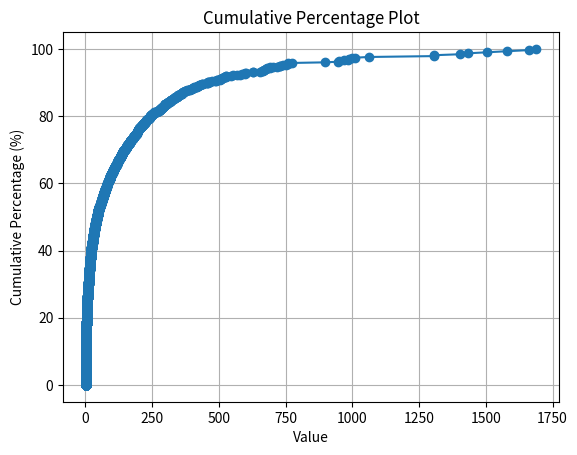

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 計算累積百分比
all_route = all_route.sort_values("路線次數",ascending=True)
all_route['CumulativePercentage'] = all_route['路線次數'].cumsum() / all_route['路線次數'].sum() * 100

# 繪製累積百分比圖
plt.plot(all_route['路線次數'], all_route['CumulativePercentage'], marker='o')
plt.title('Cumulative Percentage Plot')
plt.xlabel('Value')
plt.ylabel('Cumulative Percentage (%)')
plt.grid(True)
plt.show()

In [9]:
all_route.query("CumulativePercentage >= 80")

,借車站,還車站,lat_start,lng_start,lat_end,lng_end,路線次數,平均租借,付費,weekend,CumulativePercentage
9697,南昌公園,和平重慶路口,25.026979,121.520813,25.027229,121.516586,244,4.563456,1,55,80.020466
34469,捷運市政府站(3號出口),松仁路95巷口,25.040840,121.567886,25.036560,121.568657,245,5.091701,1,53,80.069916
25443,捷運公館站(2號出口),臺大總圖書館西南側,25.014910,121.534378,25.016899,121.540314,245,5.125850,2,88,80.119366
33299,捷運大橋頭站(2號出口),民族延平路口,25.063141,121.513077,25.068640,121.510696,245,7.231769,3,66,80.168816
24832,捷運信義安和站(4號出口),臨江街夜市(基隆路),25.033051,121.553780,25.029310,121.557213,246,12.715312,11,53,80.218467
...,...,...,...,...,...,...,...,...,...,...,...
29655,捷運台北101/世貿站(2號出口),臺北醫學大學,25.032700,121.561569,25.026680,121.561752,1434,6.346525,9,375,98.700782
25459,捷運公館站(2號出口),臺灣科技大學後門,25.014910,121.534378,25.011820,121.541649,1503,6.808173,12,532,99.004142
26585,捷運劍潭站(2號出口),百齡國小,25.083879,121.525352,25.085211,121.519180,1581,8.580297,34,466,99.323244
25458,捷運公館站(2號出口),臺灣科技大學側門,25.014910,121.534378,25.012951,121.539726,1663,5.152455,6,382,99.658897


In [67]:
all_route.query("CumulativePercentage >= 60")

,借車站,還車站,lat_start,lng_start,lat_end,lng_end,路線次數,平均租借,付費,weekend,CumulativePercentage
34205,捷運小巨蛋站(5號出口),民生光復路口,25.051760,121.553520,25.058340,121.554962,84,8.144643,1,11,60.005813
23633,捷運中山站(5號出口),歸綏戲曲公園,25.052959,121.519379,25.058050,121.513527,84,10.666865,1,26,60.022767
22734,捷運中山國中站,民權建國路口(南側),25.061060,121.544060,25.062281,121.537018,84,7.431548,2,33,60.039721
34804,捷運後山埤站(2號出口),南港公園(福德街),25.043949,121.581841,25.041281,121.590889,84,8.840278,3,35,60.056676
33513,捷運大直站(3號出口),樂群二敬業四路口,25.079229,121.547302,25.079760,121.558128,84,10.095437,3,17,60.073630
...,...,...,...,...,...,...,...,...,...,...,...
29655,捷運台北101/世貿站(2號出口),臺北醫學大學,25.032700,121.561569,25.026680,121.561752,1434,6.346525,9,375,98.700782
25459,捷運公館站(2號出口),臺灣科技大學後門,25.014910,121.534378,25.011820,121.541649,1503,6.808173,12,532,99.004142
26585,捷運劍潭站(2號出口),百齡國小,25.083879,121.525352,25.085211,121.519180,1581,8.580297,34,466,99.323244
25458,捷運公館站(2號出口),臺灣科技大學側門,25.014910,121.534378,25.012951,121.539726,1663,5.152455,6,382,99.658897


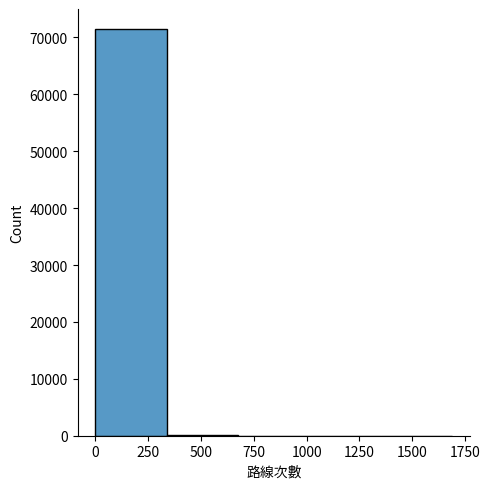

In [51]:
sns.displot(all_route, x="路線次數", bins=5)  # Adjust bins as needed
plt.show()

cluster
 1     51989
 3     13816
 2      2499
-1      2269
 9       590
 11      172
 12       39
 17       33
 15       26
 0        20
 5        15
 13       13
 14       13
 16       12
 4        10
 10       10
 18       10
 6         8
 7         7
 8         4
Name: count, dtype: int64


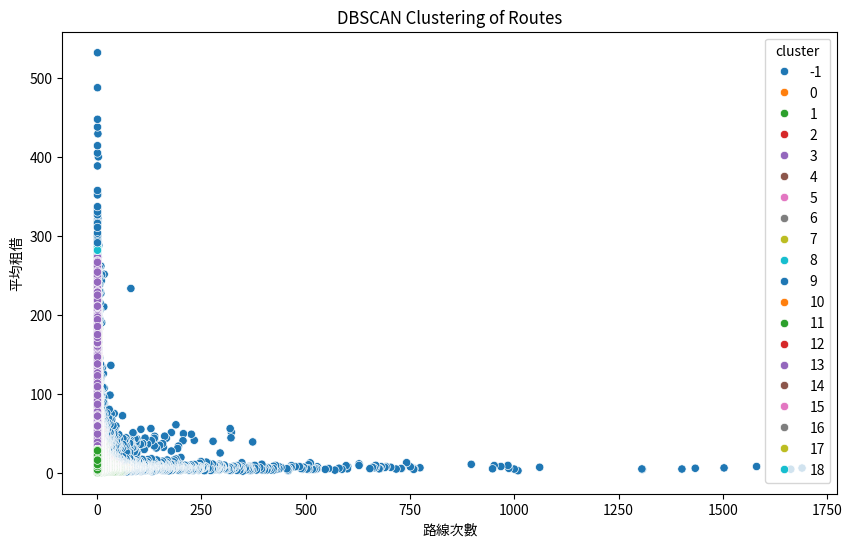

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns

# 假設你已經有 all_route 資料
# 選擇有用的特徵進行聚類
features = ['路線次數', '平均租借', '付費', 'weekend']

# 標準化數據
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_route[features])

# 應用 DBSCAN 聚類
dbscan = DBSCAN(eps=0.2, min_samples=10)
all_route['cluster'] = dbscan.fit_predict(X_scaled)

# 檢查聚類結果
print(all_route['cluster'].value_counts())

# 繪製聚類結果的散點圖 (選擇其中的兩個特徵進行可視化)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_route['路線次數'], y=all_route['平均租借'], hue=all_route['cluster'], palette='tab10')
plt.title('DBSCAN Clustering of Routes')
plt.xlabel('路線次數')
plt.ylabel('平均租借')
plt.show()

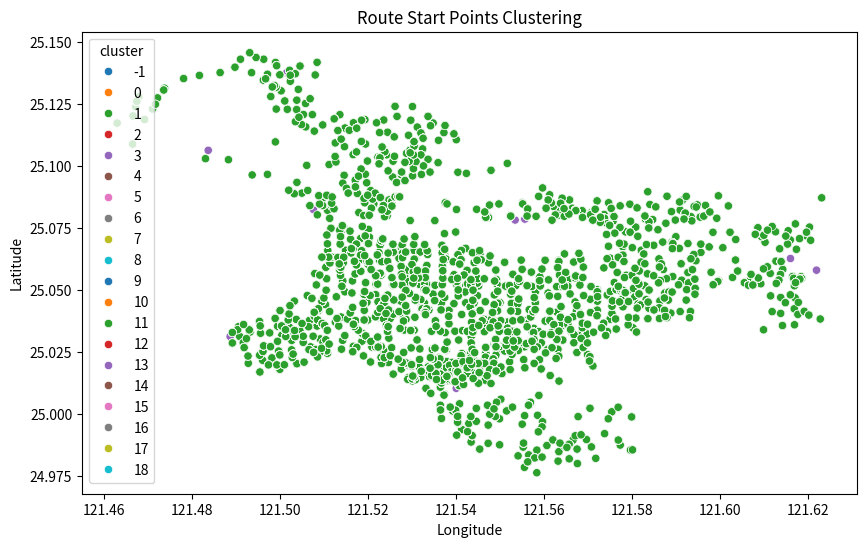

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_route['lng_start'], y=all_route['lat_start'], hue=all_route['cluster'], palette='tab10')
plt.title('Route Start Points Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

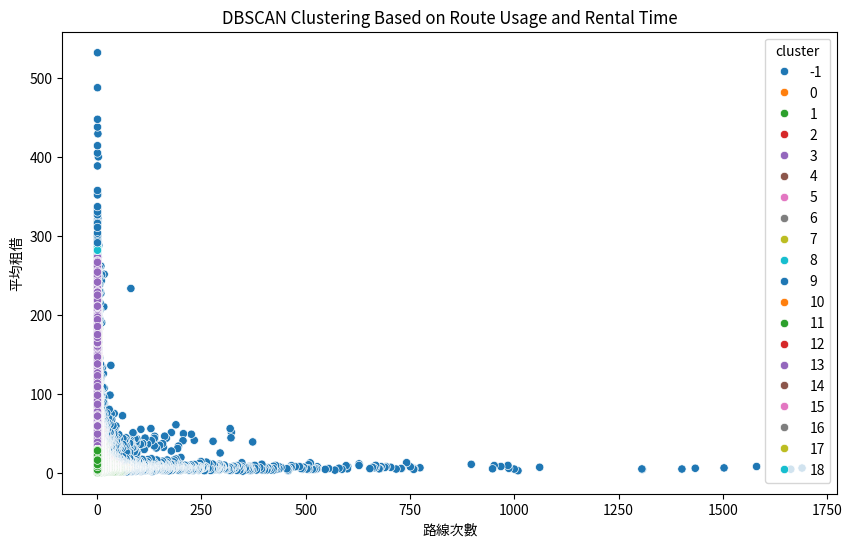

In [12]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=all_route['路線次數'], y=all_route['平均租借'], hue=all_route['cluster'], palette='tab10')
plt.title('DBSCAN Clustering Based on Route Usage and Rental Time')
plt.xlabel('路線次數')
plt.ylabel('平均租借')
plt.show()


In [11]:
cluster_10 = all_route[all_route['cluster'] == 10]
print(cluster_10.describe())

cluster_14 = all_route[all_route['cluster'] == 14]
print(cluster_14.describe())

       lat_start   lng_start    lat_end     lng_end      路線次數       平均租借  \
count  10.000000   10.000000  10.000000   10.000000  10.00000  10.000000   
mean   25.062809  121.530762  25.063057  121.532532  18.90000  32.780825   
std     0.036299    0.027849   0.036557    0.029667   2.13177   2.301761   
min    25.020210  121.498169  25.011820  121.498619  16.00000  29.989583   
25%    25.040999  121.513773  25.040802  121.512205  18.00000  31.159649   
50%    25.055940  121.523914  25.057395  121.523167  19.00000  32.436233   
75%    25.079055  121.540798  25.079085  121.542885  19.00000  33.895197   
max    25.132010  121.594780  25.132580  121.594780  24.00000  36.425926   

         付費    weekend  cluster  
count  10.0  10.000000     10.0  
mean    8.0   4.000000     10.0  
std     0.0   0.666667      0.0  
min     8.0   3.000000     10.0  
25%     8.0   4.000000     10.0  
50%     8.0   4.000000     10.0  
75%     8.0   4.000000     10.0  
max     8.0   5.000000     10.0  
       la

In [ ]:
all_route

In [12]:
temp = all_route.query("借車站 ==還車站").sort_values("路線次數",ascending=False)
temp["rate"] = temp["付費"] / temp["路線次數"]

In [18]:
temp.sort_values(["路線次數","rate"],ascending=False).to_csv("test.csv",index=False,encoding="utf-8")

##### 每個站選10條路線

In [208]:
top_10 = pd.DataFrame()
for station in all_route["借車站"].unique():
    station_top10 = all_route.query(f"借車站 == '{station}'").sort_values("路線次數",ascending=False).head(10)
    top_10 = pd.concat([top_10, station_top10])

In [ ]:
top_10

In [210]:
from matplotlib.colors import LinearSegmentedColormap

routes_pattern = all_route.copy()
routes_pattern["付費比率"] = routes_pattern["付費"] / routes_pattern["路線次數"]

filtered = pd.DataFrame()
for sna in routes_pattern["借車站"].unique():
    station = routes_pattern.query(f"借車站 == '{sna}'")
    station = station.sort_values(by = ["路線次數","付費比率"],ascending=False).head(10)
    filtered = pd.concat([filtered,station])

free_ride = filtered.query("付費比率 ==0")
paid_ride = filtered.query("付費比率 !=0 ")

In [ ]:
filtered.路線次數.sum()

In [ ]:
借出 = all_route.groupby("借車站",as_index=False).agg(借出總量 = ("路線次數","sum"),付費 = ("付費","sum"))
借出['pr'] = 借出["付費"] /  借出["借出總量"]
print(借出["借出總量"].sum())
借出.sort_values(["付費","pr"],ascending=False)

In [ ]:
還入= all_route.groupby("還車站",as_index=False).agg(還入總量 = ("路線次數","sum"),付費 = ("付費","sum"))
還入['pr'] = 還入["付費"] /  還入["還入總量"]
print(還入["還入總量"].sum())
還入.sort_values(["付費","pr"],ascending=False)

In [ ]:
free_ride

In [ ]:
monthly

In [ ]:
paid_ride.sort_values("路線次數",ascending=False).路線次數.describe()

In [ ]:
mymap = folium.Map(location=[25.065,121.56], zoom_start=12,
            tiles='https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ',
            attr='Mapbox')

def get_color_from_ratio(ratio):

    # 從灰色到橘色
    colors = ['#808080', '#FFA500']
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
    rgba_color = cmap(ratio)
    hex_color = mcolors.to_hex(rgba_color)
    
    return hex_color

def get_op(route):
    if route > 15:
        return 1
    elif route > 5:
        return 0.6
    else:
        return 0.1

# 繪製無付費紀錄的路線
for row in free_ride.to_dict(orient = "records"):
    folium.PolyLine(
        locations=[(row['lat_start'], row['lng_start']), (row['lat_end'], row['lng_end'])],
        color=get_color_from_ratio(row["付費比率"]),  
        weight = min(2 * (row["路線次數"] ** 0.5 / filtered["路線次數"].mean() ** 0.5), 3) ,
        opacity = get_op(row["路線次數"])       
    ).add_to(mymap)

# 繪製至少有一筆付費紀錄的路線
for row in paid_ride.to_dict(orient = "records"):
    folium.PolyLine(
        locations=[(row['lat_start'], row['lng_start']), (row['lat_end'], row['lng_end'])],
        color=get_color_from_ratio(row["付費比率"]),  
        weight = min(2 * (row["路線次數"] ** 0.5 / filtered["路線次數"].mean() ** 0.5), 3) ,
        opacity = get_op(row["路線次數"])
    ).add_to(mymap)

# 借出站點繪製
for _, row in filtered[["借車站","lat_start","lng_start"]].drop_duplicates().iterrows():
    folium.CircleMarker(
        location=[row['lat_start'], row['lng_start']],
        radius=1,  
        tooltip=folium.Tooltip(f"<div style='font-size: 18px;'>站點: {row['借車站']}</div>"),  
        color="red",  
        fill=True,
        fill_color="red", 
        fill_opacity=0.4  
    ).add_to(mymap)

# 還入站點繪製
for _, row in filtered[["還車站","lat_end","lng_end"]].drop_duplicates().iterrows():
    folium.CircleMarker(
        location=[row['lat_end'], row['lng_end']],
        radius=1,  
        tooltip=folium.Tooltip(f"<div style='font-size: 18px;'>站點: {row['還車站']}</div>"),  
        color="red",  
        fill=True,
        fill_color="red", 
        fill_opacity=0.4  
    ).add_to(mymap)

# 同站租還
same_s = filtered.loc[filtered["借車站"] == filtered["還車站"]].query("付費比率 !=0")
for _, row in same_s.iterrows():
    folium.CircleMarker(
        location=[row['lat_end'], row['lng_end']],
        radius = row["付費比率"]/50,  
        tooltip=folium.Tooltip(f"<div style='font-size: 18px;'>站點: {row['還車站']}</div>"),  
        color="green",
        fill=True,
        fill_color="green", 
        fill_opacity=0.4  
    ).add_to(mymap)

legend_html = """
        <div style="
        position: fixed;
        top: 20px; 
        left: 50%; 
        transform: translateX(-50%);
        width: auto; 
        height: auto;
        background-color: rgba(255, 255, 255, 0.8);
        border: 2px solid grey; 
        z-index: 9999; 
        font-size: 16px; 
        line-height: 1.6;
        border-radius: 15px; 
        padding: 10px;
        text-align: center;
        ">
        <strong style="font-size: 18px;">Legend</strong> <br>
        <div style="display: flex; flex-direction: column; justify-content: center; align-items: flex-start; margin-top: 10px;">
            <div style="display: flex; align-items: center; margin-bottom: 5px;">
                <i style="background:gray; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
                <span style="font-size: 14px; margin-left: 10px;"> "免費" 路線: 顏色越深、越粗代表越多人騎乘 </span>
            </div>
            <div style="display: flex; align-items: center; margin-bottom: 5px;">
                <i style="background:orange; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
                <span style="font-size: 14px; margin-left: 10px;"> "付費" 路線: 顏色越深、越粗代表越這條路線有較高的比率會產生收入 </span>
            </div>
            
        </div>
    </div>
"""

mymap.get_root().html.add_child(folium.Element(legend_html))
mymap

##### 見車率

In [ ]:
gpd.read_file("D:\sandbox_git\warehouse\見車率_202307.geojson")

In [49]:
conn = duckdb.connect(database='warehouse\data_sandbox.duckdb')
df = conn.execute("SELECT * FROM youbike").fetch_df()[["sna","available_return_bikes","infoTime","latitude","longitude","infoDate","total"]]
conn.close()

In [ ]:
df[["sna","latitude","longitude","total"]].drop_duplicates(subset="sna").sort_values("total",ascending=False).total.describe()

In [ ]:
df[["sna","latitude","longitude","total"]].drop_duplicates(subset="sna").sort_values("total",ascending=False).head(10)

In [ ]:
# df = gpd.read_file("D:\sandbox_git\warehouse\見車率_202307.geojson")

m = folium.Map(location=[25.08,121.53], zoom_start=12,
               tiles='https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ',
                attr='Mapbox')

def get_color(number):
    number = int(number)
    if number  < 15:
        return "black"
    elif number >80:
        return "red"
    elif number > 31:
        return "orange"
    else:
        return "gray"
    
def get_opa(color):
    if color in ["black","gray"]:
        return 0.4
    else:
        return 0.8

for _, row in df[["sna","latitude","longitude","total"]].drop_duplicates(subset="sna").sort_values("total",ascending=True).iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=max(row["total"]/10,3),  # 調整點的大小，避免過度擁擠
        tooltip=folium.Tooltip(f"<div style='font-size: 18px;'>站點: {row['sna']}, 有{row['total']}個車位</div>"),  # 彈出窗口顯示 pattern
        color= get_color(row["total"]),  # 點的邊框顏色
        fill=True,
        fill_color= get_color(row["total"]),  # 點的填充顏色
        fill_opacity= get_opa(get_color(row["total"])) # 增加透明度
    ).add_to(m)


legend_html = """
     <div style="
     position: fixed;
     top: 20px; left: 50%; transform: translateX(-50%);
     width: auto; height: auto;
     background-color: rgba(255, 255, 255, 0.8);
     border: 2px solid grey; z-index: 9999; font-size: 16px; line-height: 1.6;
     border-radius: 15px; padding: 10px;
     text-align: center;
     ">
     <strong style="font-size: 18px;">Legend</strong> <br>
     <div style="display: flex; flex-direction: column; justify-content: center; align-items: flex-start; margin-top: 10px;">
        <div style="display: flex; align-items: center; margin-bottom: 5px;">
            <i style="background:black; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 14px; margin-left: 10px;"> 低於15輛(<25%) </span>
        </div>
        <div style="display: flex; align-items: center; margin-bottom: 5px;">
            <i style="background:gray; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 14px; margin-left: 10px;"> 中 </span>
        </div>
        <div style="display: flex; align-items: center; margin-bottom: 5px;">
            <i style="background:orange; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 14px; margin-left: 10px;"> 高(>75%) </span>
        </div>
        <div style="display: flex; align-items: center;">
            <i style="background:red; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 14px; margin-left: 10px;"> 前10名(>80輛) </span>
        </div>
     </div>
</div>

     """

# 在地圖上添加圖例
m.get_root().html.add_child(folium.Element(legend_html))

# 保存地圖為 HTML 文件
m.save(r"D:\sandbox_git\project\map_application\static\distribute.html")

# 在 Jupyter Notebook 中顯示地圖
m


In [51]:
df = df.query("infoDate == '2024-09-30'")
zt = df.query("available_return_bikes ==0").groupby(["sna"],as_index=False).agg(zt = ("sna","count"))
df = df.query("available_return_bikes !=0").groupby(["sna","latitude","longitude"],as_index=False).agg(nzt = ("sna","count"))\
.merge(zt,how="left",on="sna").fillna(0)
df["zsr"] = 1- df["zt"] / (df["nzt"]+ df["zt"])
def rate(row):
    if row <0.6:
        return "低"
    elif row >= 0.9:
        return "高"
    else:
        return "中"
df["見車率"] = df["zsr"].apply(rate)

In [ ]:
df

In [ ]:
# df = gpd.read_file("D:\sandbox_git\warehouse\見車率_202307.geojson")

m = folium.Map(location=[25.04,121.56], zoom_start=12,
               tiles='https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ',
                attr='Mapbox')

color_map = {
    "低":"red",
    "中":"orange",
    "高":"green"
}

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,  # 調整點的大小，避免過度擁擠
        tooltip=folium.Tooltip(f"<div style='font-size: 18px;'>站點: {row['sna']}</div>"),  # 彈出窗口顯示 pattern
        color=color_map[row['見車率']],  # 點的邊框顏色
        fill=True,
        fill_color=color_map[row['見車率']],  # 點的填充顏色
        fill_opacity=0.8  # 增加透明度
    ).add_to(m)

legend_html = """
     <div style="
     position: fixed;
     top: 20px; left: 50%; transform: translateX(-50%);
     width: 200px; height: auto;
     background-color: rgba(255, 255, 255, 0.8);
     border:2px solid grey; z-index:9999; font-size:20px; line-height: 1.6;
     border-radius: 15px; padding: 10px;
     text-align: center;
     ">
     <strong>見車率分類</strong> <br>
     <p>2024-09-30</p>
     <div style="display: flex; justify-content: space-around; align-items: center; margin-top: 10px;">
        <div>
            <i style="background:red; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 20px;">低</span>
        </div>
        <div>
            <i style="background:orange; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 20px;">中</span>
        </div>
        <div>
            <i style="background:green; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 20px;">高</span>
        </div>
     </div>
     </div>
     """


# 在地圖上添加圖例
m.get_root().html.add_child(folium.Element(legend_html))

# 保存地圖為 HTML 文件
m.save(r"D:\sandbox_git\project\map_application\static\見車率_0930.html")

# 在 Jupyter Notebook 中顯示地圖
m


In [ ]:
gpd.read_file("D:\sandbox_git\warehouse\見車率_202307.geojson")

In [ ]:
# df = gpd.read_file("D:\sandbox_git\warehouse\見車率_202307.geojson")

m = folium.Map(location=[25.04,121.56], zoom_start=12,
               tiles='https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ',
                attr='Mapbox')

color_map = {
    "低":"red",
    "中":"orange",
    "高":"green"
}

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,  # 調整點的大小，避免過度擁擠
        tooltip=folium.Tooltip(f"<div style='font-size: 18px;'>站點: {row['stop_name']}</div>"),  # 彈出窗口顯示 pattern
        color=color_map[row['category']],  # 點的邊框顏色
        fill=True,
        fill_color=color_map[row['category']],  # 點的填充顏色
        fill_opacity=0.8  # 增加透明度
    ).add_to(m)

legend_html = """
     <div style="
     position: fixed;
     top: 20px; left: 50%; transform: translateX(-50%);
     width: 200px; height: auto;
     background-color: rgba(255, 255, 255, 0.8);
     border:2px solid grey; z-index:9999; font-size:20px; line-height: 1.6;
     border-radius: 15px; padding: 10px;
     text-align: center;
     ">
     <strong>見車率分類</strong> <br>
     <div style="display: flex; justify-content: space-around; align-items: center; margin-top: 10px;">
        <div>
            <i style="background:red; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 20px;">低</span>
        </div>
        <div>
            <i style="background:orange; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 20px;">中</span>
        </div>
        <div>
            <i style="background:green; width: 20px; height: 20px; display:inline-block; border-radius: 50%;"></i>
            <span style="font-size: 20px;">高</span>
        </div>
     </div>
     </div>
     """


# 在地圖上添加圖例
m.get_root().html.add_child(folium.Element(legend_html))

# 保存地圖為 HTML 文件
# m.save(r"D:\sandbox_git\project\map_application\static\見車率.html")

# 在 Jupyter Notebook 中顯示地圖
m


In [ ]:
import os

# 定義文件夾路徑
folder_path = r'D:\sandbox_git\warehouse\bike_html'

# 列出文件夾中的所有 HTML 文件
html_files = [f for f in os.listdir(folder_path) if f.endswith('.html')]

# 創建每個 HTML 檔案對應的 section
html_sections = ""

for html_file in html_files:
    section = f"""
    <div class="section">
        <iframe src="{folder_path}\\{html_file}" width="100%" height="100%"></iframe>
    </div>
    """
    html_sections += section

# 打印生成的 sections
print(html_sections)


##### k means

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
from kneed import KneeLocator
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# 讀取腳踏車站點資料 (假設為 CSV 格式，包含 latitude 和 longitude 欄位)
conn = duckdb.connect(database='warehouse\data_sandbox.duckdb')
df = conn.execute("select distinct sno,sna,latitude,longitude from youbike").fetch_df()
conn.close()

# 提取經緯度數據
X = df[['latitude', 'longitude']].values

# 標準化經緯度數據
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 使用 KMeans 進行分群
# 計算不同群數的 WCSS (Within-Cluster Sum of Squares)
wcss = []
k_values = range(1, 140)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # KMeans 中的 inertia_ 屬性即為 WCSS

# 使用 KneeLocator 來找到肘部點
kneedle = KneeLocator(k_values, wcss, curve="convex", direction="decreasing")
k = kneedle.knee
print(f"optimal k = {k}")
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# 讀取 OSM 行政區資料 (假設為 GeoJSON 格式)
gdf_osm = gpd.read_file('D:\sandbox_git\project\map_application\static\geojson\OSM_DATA.geojson')  # 替換為你的實際檔案路徑

# 將腳踏車站點資料轉換為 GeoDataFrame (經緯度 -> 幾何點)
gdf_stations = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

# 設定坐標系統為 WGS 84 (EPSG:4326)，以便與 OSM 資料匹配
gdf_stations.set_crs(epsg=4326, inplace=True)

# 繪製地圖
fig, ax = plt.subplots(figsize=(20, 20))

# 繪製行政區邊界
gdf_osm.boundary.plot(ax=ax, color='black', linewidth=1)
for idx, row in gdf_osm.iterrows():
    # 計算每個行政區的中心點 (centroid)
    centroid = row['geometry'].centroid
    # 在地圖上繪製名稱 (name 欄位)
    plt.text(centroid.x, centroid.y, row['name'], horizontalalignment='center', fontsize=10, color='blue')

# 繪製分群結果
gdf_stations.plot(ax=ax, column='cluster', cmap='viridis', legend=True, markersize=50, alpha=0.6)

# 設定標題和顯示
plt.title(f'KMeans Clustering of {len(df)} Bike Stations with OSM Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


DBSCAN

In [13]:
conn = duckdb.connect(database='warehouse\data_sandbox.duckdb')
df = conn.execute("select distinct sno,sna,latitude,longitude from youbike").fetch_df()
conn.close()

In [14]:
df

,sno,sna,latitude,longitude
0,500106074,王貫英先生紀念圖書館,25.022659,121.523621
1,500108105,陽光街161巷口,25.074329,121.585838
2,500111084,忠孝東路六段212巷口,25.048800,121.587418
3,500108016,捷運大湖公園站(2號出口),25.083950,121.601852
4,500107088,南京伊通街口,25.051889,121.535172
...,...,...,...,...
1453,500106095,仁愛杭州路口,25.038460,121.524971
1454,500107091,臺北市立圖書館大直分館,25.081520,121.546463
1455,500112065,松德公園,25.036570,121.573486
1456,500105060,實踐國中(木新路三段310巷口),24.983391,121.556450


In [21]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from numpy import radians

# 將經緯度轉換為弧度
df['latitude_radians'] = np.radians(df['latitude'])
df['longitude_radians'] = np.radians(df['longitude'])

# 使用 NearestNeighbors 設置為 haversine 度量
X = df[['latitude_radians', 'longitude_radians']].values

# 找最近的鄰居，度量方式使用 'haversine'
neighbors = NearestNeighbors(n_neighbors=2, metric='haversine')
neighbors_fit = neighbors.fit(X)

# 計算每個點到最近鄰的距離，這裡的距離是地球弧度距離
distances, indices = neighbors_fit.kneighbors(X)

# 將弧度距離轉換為公里，地球半徑約為 6371 公里
distances_in_km = distances[:, 1] * 6371

# 將最近鄰站點及其距離加入到 df 中
df['最近鄰站點'] = df.iloc[indices[:, 1]]['sna'].values  # 根據索引找到最近鄰的站點名稱
df['最近鄰距離_km'] = distances_in_km  # 最近鄰的距離（公里）

# 顯示結果
print(df[['sno', 'sna', 'latitude', 'longitude', '最近鄰站點', '最近鄰距離_km']].head())

         sno            sna   latitude   longitude        最近鄰站點  最近鄰距離_km
0  500106074     王貫英先生紀念圖書館  25.022659  121.523621         河堤國小  0.073986
1  500108105       陽光街161巷口  25.074329  121.585838   文德二號公園(南側)  0.224830
2  500111084    忠孝東路六段212巷口  25.048800  121.587418  忠孝東路六段225巷口  0.100694
3  500108016  捷運大湖公園站(2號出口)  25.083950  121.601852       金湖星雲街口  0.503148
4  500107088         南京伊通街口  25.051889  121.535172       南京建國路口  0.166082


In [30]:
df["最近鄰距離_km"].mean()* 1000

160.63871206571878

In [32]:
df

,sno,sna,latitude,longitude,最近鄰站點,最近鄰距離,latitude_radians,longitude_radians,最近鄰距離_km
0,500106074,王貫英先生紀念圖書館,25.022659,121.523621,河堤國小,0.000741,0.436728,2.120987,0.073986
1,500108105,陽光街161巷口,25.074329,121.585838,文德二號公園(南側),0.002208,0.437630,2.122073,0.224830
2,500111084,忠孝東路六段212巷口,25.048800,121.587418,忠孝東路六段225巷口,0.000982,0.437184,2.122101,0.100694
3,500108016,捷運大湖公園站(2號出口),25.083950,121.601852,金湖星雲街口,0.004671,0.437798,2.122353,0.503148
4,500107088,南京伊通街口,25.051889,121.535172,南京建國路口,0.001644,0.437238,2.121189,0.166082
...,...,...,...,...,...,...,...,...,...
1453,500112101,革新公園,25.043671,121.567413,基隆路一段101巷口,0.001542,0.437095,2.121752,0.170309
1454,500109063,奇岩4號綠地,25.125330,121.505730,清江國小,0.002179,0.438520,2.120675,0.237203
1455,500101240,和平東路二段76巷,25.022631,121.539062,臺大思亮館東南側,0.001890,0.436727,2.121257,0.210187
1456,500111039,凌雲五村(研究院路三段8巷),25.035950,121.616882,凌雲市場,0.002749,0.436960,2.122615,0.277387


In [37]:
import folium
import matplotlib.pyplot as plt
import numpy as np

# 創建地圖，設置為台北市的中心，使用 Stamen Toner 灰色系底圖
m = folium.Map(location=[25.033, 121.565], zoom_start=12,
            tiles='https://api.mapbox.com/styles/v1/mapbox/light-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2hpYm55IiwiYSI6ImNrcWtjMDg0NjA0anQyb3RnZnl0cDJkYmYifQ.hqyJUg0ZRzAZbcJwkfs0bQ',
            attr='Mapbox')

# 根據距離生成顏色映射
# 正規化距離以得到介於0到1之間的值
norm = plt.Normalize(vmin=df['最近鄰距離_km'].min(), vmax=df['最近鄰距離_km'].max())
# 使用 'coolwarm' 顏色映射，或者可以選擇其他色彩映射
cmap = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')

# 繪製每個站點與其最近鄰站點的連接線，並根據距離長短設置顏色
for i in range(len(df)):
    lat_start = df.loc[i, 'latitude']
    lon_start = df.loc[i, 'longitude']
    
    # 獲取最近鄰站點的經緯度
    nearest_station_index = df[df['sna'] == df.loc[i, '最近鄰站點']].index[0]
    lat_end = df.loc[nearest_station_index, 'latitude']
    lon_end = df.loc[nearest_station_index, 'longitude']
    
    # 獲取距離
    distance = df.loc[i, '最近鄰距離_km']
    
    # 根據距離獲取對應顏色
    color = plt.cm.coolwarm(norm(distance))
    color_hex = f'#{int(color[0]*255):02x}{int(color[1]*255):02x}{int(color[2]*255):02x}'
    
    # 畫出線條，顏色基於距離長短
    folium.PolyLine(locations=[(lat_start, lon_start), (lat_end, lon_end)],
                    color=color_hex, weight=2.5, opacity=0.7).add_to(m)

# 保存地圖到 html 文件
m.save('nearest_neighbors_map_with_colors.html')

# 顯示地圖
m


In [12]:
pd.read_csv(r"D:\\sandbox_git\\warehouse\\YouBike臺北市每月使用量.csv", encoding='big5')

,民國年月,臺北市YouBike每月使用量（次數）
0,10911,2730442
1,10912,2072168
2,11001,2291365
3,11002,2208191
4,11003,2799636
5,11004,2717801
6,11005,1956980
7,11006,1147429
8,11007,1578183
9,11008,2070079
